# Problem 1
Remember from last week we discussed that skewness and kurtosis functions in statistical packages are often biased. Is your function biased? Prove or disprove your hypothesis.

In [ ]:
# First load all libraries needed to solve this problem, using "pip install" would be necessary if any libraries are reported missing in local environment.
import numpy as np
from scipy.stats import kurtosis, ttest_1samp, t, describe, norm, skew
from math import sqrt

In [ ]:
sample_size = [100, 1000, 100000] # as we know, when sample size increases, the biased and unbiased parameters should converge to their true value, and we are interested in whether it is true, so we allow it to vary
sample_round = [100, 1000] # as shown during class, with fewer sample rounds (we have less kurtosis to examine), we have less statistical power to detect bias, even if it exists, and we are also interested in whether it is true, so we also allow it to vary

expected_kurt = 0 # the expected kurtosis for normal distribution in scipy package is adjusted to be 0
threshold = 0.05 # the threshold that we consider statistically significant
for i in sample_size:
    num_kurts = 0 # help to track the numbers of kurtosis generated
    for j in sample_round:
        print("current sample size is", i)
        print("current sample round is", j)
        kurts_b = np.empty(j) # initialize an empty dataframe of numbers = sample_round to store kurt_biased calculated during this loop
        kurts_ub = np.empty(j) # empty dataframe for kurt_unbiased
        data = np.random.normal(0, 1, i) # initialize random normal distributed data to calculate kurt
        kurts_b[num_kurts] = kurtosis(data) # generate the kurtosis_biased from the random normal distribution
        kurts_ub[num_kurts] = kurtosis(data, bias = False) # generate the kurtosis_unbiased
        t_stat, p_val = ttest_1samp(kurts_b, expected_kurt) # test the kurtosis_biased

        mean_kurts_b = np.mean(kurts_b)
        mean_kurts_ub = np.mean(kurts_ub)
        print("during this assessment, the biased kurtosis is", mean_kurts_b, ", the unbiased kurtosis is", mean_kurts_ub)

        if p_val < threshold:
            print("we rejected null hypothesis and it is biased")
        else:
            print("we fail to reject null hypothesis and it can be unbiased")

        num_kurts += 1
        print("")

In [ ]:
# same procedure, but to test the skewness
sample_size = [10, 1000, 100000]
sample_round = [10, 100, 1000]

expected_skew = 0 # the expected skewness for normal distribution is 0
threshold = 0.05
for i in sample_size:
    num_skews = 0
    for j in sample_round:
        print("current sample size is {}" .format(i))
        print("current sample round is {}" .format(j))
        skews_b = np.empty(j)
        skews_ub = np.empty(j)
        data = np.random.normal(0, 1, i) # initialize random normal distributed data to calculate skew
        skews_b[num_skews] = skew(data)
        skews_ub[num_skews] = skew(data, bias = False)
        t_stat, p_val = ttest_1samp(skews_b, expected_skew)
        if p_val < threshold:
            print("p-value is", p_val, ", and we rejected null hypothesis and it is biased")
        else:
            print("p-value is", p_val, ", and we fail to reject null hypothesis and it can be unbiased")

        mean_skews_b = np.mean(skews_b)
        mean_skews_ub = np.mean(skews_ub)
        print("during this assessment, the biased skewness is", mean_skews_b, ", the unbiased skewness is", mean_skews_ub)

        num_skews += 1
        print("")

# Caveat: no random seeds have been set during normal distribution generation process, results may differ each time the code runs

# Problem 2
Fit the data in problem2.csv using OLS and calculate the error vector. Look at its distribution. How well does it fit the assumption of normally distributed errors? Fit the data using MLE given the assumption of normality. Then fit the MLE using the assumption of a T distribution of the errors. Which is the best fit? What are the fitted parameters of each and how do they compare? What does this tell us about the breaking of the normality assumption in regards to expected values in this case?

In [7]:
# load library
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew, t, ttest_1samp, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize

In [8]:
# load the data to dataframe
df = pd.read_csv("problem2.csv")
Y = df["y"]
x = df["x"]
X = sm.add_constant(x)

# OLS fit under normal distribution
OLS = sm.OLS(Y, X)
OLS_result = OLS.fit()
print(OLS_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     23.68
Date:                Fri, 08 Sep 2023   Prob (F-statistic):           4.34e-06
Time:                        12:15:21   Log-Likelihood:                -159.99
No. Observations:                 100   AIC:                             324.0
Df Residuals:                      98   BIC:                             329.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1198      0.121      0.990      0.3

0   -0.838485
1    0.835296
2    1.027428
3    1.319711
4   -0.152317
dtype: float64


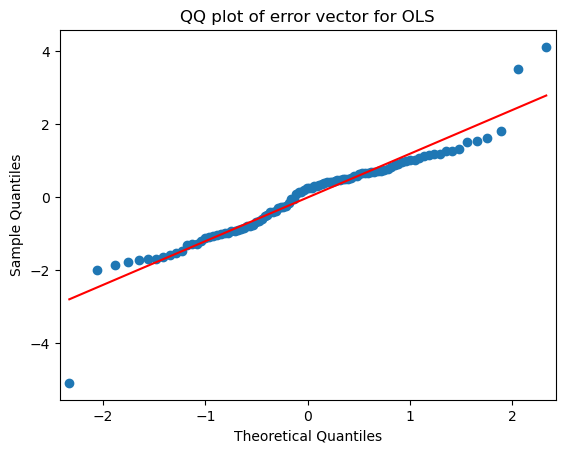

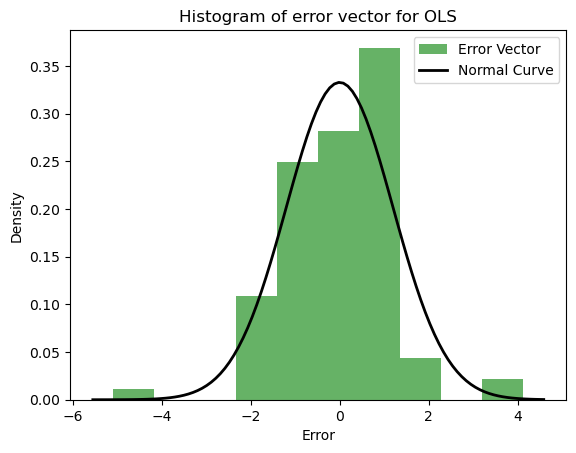

In [17]:
# obtain OLS's residual
Y_predict = OLS_result.predict(X)
err_vec_ols = Y - Y_predict

print(err_vec_ols.head())

# examine OLS's residual
mean_res_ols = np.mean(err_vec_ols)
var_res_ols = np.var(err_vec_ols)
skew_res_ols = skew(err_vec_ols)
kur_res_ols = kurtosis(err_vec_ols)
# print("the mean of residual obtained through OLS is {}" .format(mean_res_ols))

# visualisation: QQ plot
fig = sm.qqplot(err_vec_ols, line='s')  # 's' for standardized line
plt.title("QQ plot of error vector for OLS")
plt.show()

# visualisation: histogram and normal distribution
plt.hist(err_vec_ols, bins=10, density=True, alpha=0.6, color='g', label='Error Vector')

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(err_vec_ols), np.std(err_vec_ols))
plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')

# Add labels and title
plt.title("Histogram of error vector for OLS")
plt.xlabel('Error')
plt.ylabel('Density')
plt.legend()

# Show plot
plt.show()

In [52]:
# below we would assess the goodness of fit through R^2 and adjusted R^2, AIC and BIC
# obtain R squared and adjusted R squared
R2_ols = OLS_result.rsquared
adj_R2_ols = OLS_result.rsquared_adj
# obtain AIC and BIC
AIC_ols = OLS_result.aic
BIC_ols = OLS_result.bic
print(AIC_ols, BIC_ols)

323.9841933783246 329.1945337503008


In [36]:
# reload the data to prevent data leakage
df = pd.read_csv("problem2.csv")
Y = df["y"]
x = df["x"]
X = sm.add_constant(x) # to include the intercept term, a column of 1s are added to the feature matrix X to become [1, X1, X2,...]

# MLE fit under normal distribution
# log-likelihood function for MLE under normal distribution
def loglike_mle_nd(paras, Y, x): # para include intercept, slope and sigma, and Y is dependent variable while x is independent variable
    intercep, slope, sigma = paras
    Y_predict = intercep + slope * x
    nll = -np.sum(norm.logpdf(Y, loc = Y_predict, scale = sigma))
    return nll

# optimize and fit MLE
init = (1, 1, 1) # need initial guess to enable the optimization to start
MLE_result_nd = minimize(fun = loglike_mle_nd, x0 = init, args = (Y,x))

-3.8857805861880476e-17 1.4361484854062607 -0.26726658552879606 3.1931010009568777


In [46]:
# below we would assess the goodness of fit through error vector, R^2 and adjusted R^2, AIC and BIC
# obtain the error vector
paras_opt_mle_nd = MLE_result_nd.x
intercep_opt_mle_nd, slope_opt_mle_nd, sigma_opt_mle_nd = paras_opt_mle_nd
err_vec_mle_nd = Y - intercep_opt_mle_nd - slope_opt_mle_nd * x

mean_res_mle_nd = np.mean(err_vec_mle_nd)
var_res_mle_nd = np.var(err_vec_mle_nd)
skew_res_mle_nd = skew(err_vec_mle_nd)
kur_res_mle_nd = kurtosis(err_vec_mle_nd)

# obtain R squared and adjusted R squared
Y_predict_mle_nd = intercep_opt_mle_nd + slope_opt_mle_nd * x
TSS_mle_nd = np.sum((Y - np.mean(Y)) ** 2)
RSS_mle_nd = np.sum((err_vec_mle_nd - np.mean(err_vec_mle_nd)) ** 2)
R2_mle_nd = 1 - (RSS_mle_nd / TSS_mle_nd)

n = len(Y)  # number of observations
p = 1  # number of parameters excluding constant, num_x
adj_R2_mle_nd = 1 - ((1 - R2_mle_nd) * (n - 1) / (n - p - 1))

# obtain AIC
loglikeli_mle_nd = -MLE_result_nd.fun
AIC_mle_nd = 2 * 2 - 2 * loglikeli_mle_nd
print(AIC_mle_nd)

# obtain BIC
BIC_mle_nd = np.log(n) * 2 - 2 * loglikeli_mle_nd
print(BIC_mle_nd)

323.984193378325
329.1945337503012


In [34]:
# reload the data to prevent data leakage
df = pd.read_csv("problem2.csv")
Y = df["y"]
x = df["x"]

def loglike_mle_t(paras, Y, x):
    intercep, slope, sigma, nu = paras
    Y_predict = intercep + slope * x
    nll = -np.sum(t.logpdf(Y, df = nu, loc = Y_predict, scale = sigma ))
    return nll

init = (1,1,1,1)
MLE_result_t = minimize(fun = loglike_mle_t, x0 = init, args = (Y,x))
print(MLE_result_t)

      fun: 155.47297041247222
 hess_inv: array([[ 1.22405341e-02,  5.18555852e-04, -2.70727826e-03,
        -8.78546873e-02],
       [ 5.18555852e-04,  1.29244549e-02, -7.74787476e-05,
        -1.12637433e-03],
       [-2.70727826e-03, -7.74787476e-05,  1.16887526e-02,
         2.23793246e-01],
       [-8.78546873e-02, -1.12637433e-03,  2.23793246e-01,
         9.24888732e+00]])
      jac: array([-1.90734863e-05, -7.62939453e-06, -5.72204590e-06,  1.90734863e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 250
      nit: 16
     njev: 48
   status: 2
  success: False
        x: array([0.14261386, 0.5575716 , 0.97126576, 6.2765526 ])


In [50]:
# below we would assess the goodness of fit through error vector, R^2 and adjusted R^2, AIC and BIC
# obtain the error vector
paras_opt_mle_t = MLE_result_t.x
intercep_opt_mle_t, slope_opt_mle_t, sigma_opt_mle_t, nu_opt_mle_t = paras_opt_mle_t
err_vec_mle_t = Y - intercep_opt_mle_t - slope_opt_mle_t * x

mean_res_mle_t = np.mean(err_vec_mle_t)
var_res_mle_t = np.var(err_vec_mle_t)
skew_res_mle_t = skew(err_vec_mle_t)
kur_res_mle_t = kurtosis(err_vec_mle_t)

# obtain R squared and adjusted R squared
Y_predict_mle_t = intercep_opt_mle_t + slope_opt_mle_t * x
TSS_mle_t = np.sum((Y - np.mean(Y)) ** 2)
RSS_mle_t = np.sum((err_vec_mle_t - np.mean(err_vec_mle_t)) ** 2)
R2_mle_t = 1 - (RSS_mle_t / TSS_mle_t)
print(R2_mle_t)

n = len(Y)  # number of observations
p = 1  # number of parameters excluding constant, num_x
adj_R2_mle_t = 1 - ((1 - R2_mle_t) * (n - 1) / (n - p - 1))
print(adj_R2_mle_t)

# obtain AIC
loglikeli_mle_t = -MLE_result_t.fun
AIC_mle_t = 2 * 2 - 2 * loglikeli_mle_t
print(AIC_mle_t)

# obtain BIC
BIC_mle_t = np.log(n) * 2 - 2 * loglikeli_mle_t
print(BIC_mle_t)

0.1934338047341707
0.18520353743553986
314.94594082494444
320.15628119692065


# Problem 3
Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and PACF graphs. How do the graphs help us to identify the type and order of each process?